In [1]:
!pip install vit_keras

  Preparing metadata (setup.py) ... - done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=4105faaa4520b4a302c5333c2f031701161306cf843292bbb75a0219740137a5
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [2]:
import numpy as np
import pandas as pd
import os
import random
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from vit_keras import vit, utils, visualize

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# tf.config.run_functions_eagerly(False)

In [3]:
@dataclass
class GLOBAL:
    INPUT_PATH = "../input/100-bird-species/"
    IMAGE_SIZE = (224, 224)
    INPUT_SHAPE = (224, 224, 3)
    BATCH_SIZE = 32
    RANDOM_STATE = 42

In [4]:
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
birds_df["filepaths"] = GLOBAL.INPUT_PATH + birds_df["filepaths"]
birds_df

,class id,filepaths,labels,data set,scientific name
0,0.0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,../input/100-bird-species/train/ABBOTTS BABBLE...,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
...,...,...,...,...,...
89880,524.0,../input/100-bird-species/valid/BLACK BREASTED...,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,../input/100-bird-species/valid/BLACK BREASTED...,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,../input/100-bird-species/valid/BLACK BREASTED...,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,../input/100-bird-species/valid/BLACK BREASTED...,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


In [5]:
birds_labels = birds_df["labels"].value_counts()
birds_labels_list = birds_labels.keys().tolist()

In [6]:
def make_train_valid_test_80_10_10(df, label):
    filtered_df = birds_df[birds_df["labels"] == label]
    
    original_length = len(filtered_df)
    
    new_train_rows = int(len(filtered_df) * 0.8)
    new_valid_rows = int(len(filtered_df) * 0.1) + 1
    new_test_rows = int(len(filtered_df) * 0.1)
    
    total_sum = new_train_rows + new_valid_rows + new_test_rows
    difference = original_length - total_sum
    if original_length == total_sum:
        pass
    if difference == 1:
        if new_valid_rows > new_test_rows:
            new_valid_rows = new_valid_rows + 1
        if new_valid_rows < new_test_rows:
            new_test_rows = new_test_rows + 1
    if difference == -1:
        new_valid_rows = new_valid_rows - 1
        
    split_labels = np.array(["train"] * new_train_rows + ["valid"] * new_valid_rows + ["test"] * new_test_rows)
    
    filtered_df["new_train_valid_test_80_10_10"] = "None"
    filtered_df["new_train_valid_test_80_10_10"] = split_labels
    
    return filtered_df

In [7]:
final_df_with_split = pd.DataFrame(columns=birds_df.columns)
final_df_with_split["new_train_valid_test_80_10_10"] = None

for bird_name in birds_labels_list:
    df_to_append = make_train_valid_test_80_10_10(birds_df, bird_name)
    final_df_with_split = pd.concat([final_df_with_split, df_to_append], ignore_index=True)
    
final_df_with_split

,class id,filepaths,labels,data set,scientific name,new_train_valid_test_80_10_10
0,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
1,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
2,426.0,../input/100-bird-species/train/RUFOUS TREPE/1...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
3,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
4,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
...,...,...,...,...,...,...
89880,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89881,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89882,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89883,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test


In [8]:
df_with_valid_and_test = final_df_with_split[final_df_with_split["new_train_valid_test_80_10_10"] != "train"]
df_with_valid_and_test

,class id,filepaths,labels,data set,scientific name,new_train_valid_test_80_10_10
218,426.0,../input/100-bird-species/train/RUFOUS TREPE/2...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,valid
219,426.0,../input/100-bird-species/train/RUFOUS TREPE/2...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,valid
220,426.0,../input/100-bird-species/train/RUFOUS TREPE/2...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,valid
221,426.0,../input/100-bird-species/train/RUFOUS TREPE/2...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,valid
222,426.0,../input/100-bird-species/train/RUFOUS TREPE/2...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,valid
...,...,...,...,...,...,...
89880,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89881,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89882,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test
89883,408.0,../input/100-bird-species/valid/RED TAILED THR...,RED TAILED THRUSH,valid,NEOCOSSYPHUS RUFUS,test


In [9]:
train_df = final_df_with_split[final_df_with_split["new_train_valid_test_80_10_10"] == "train"]

valid_df, test_df = train_test_split(df_with_valid_and_test, test_size=0.5, 
                                     stratify=df_with_valid_and_test["labels"], random_state=GLOBAL.RANDOM_STATE)

labels_of_125_birds_to_drop = (train_df["labels"].unique()[401:]).tolist()

In [10]:
def keep_only_400_bird_species(df, labels_of_125_birds_to_drop, is_test):
    df_filtered = df[~df["labels"].isin(labels_of_125_birds_to_drop)]
    
    if is_test:
        df_filtered = df_filtered.iloc[:-1]
    
    return df_filtered

train_df = keep_only_400_bird_species(train_df, labels_of_125_birds_to_drop, False)
valid_df = keep_only_400_bird_species(valid_df, labels_of_125_birds_to_drop, False)
test_df = keep_only_400_bird_species(test_df, labels_of_125_birds_to_drop, True)

train_df

,class id,filepaths,labels,data set,scientific name,new_train_valid_test_80_10_10
0,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
1,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
2,426.0,../input/100-bird-species/train/RUFOUS TREPE/1...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
3,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
4,426.0,../input/100-bird-species/train/RUFOUS TREPE/0...,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,train
...,...,...,...,...,...,...
71536,22.0,../input/100-bird-species/train/AMERICAN ROBIN...,AMERICAN ROBIN,train,TURDUS MIGRATORIUS,train
71537,22.0,../input/100-bird-species/train/AMERICAN ROBIN...,AMERICAN ROBIN,train,TURDUS MIGRATORIUS,train
71538,22.0,../input/100-bird-species/train/AMERICAN ROBIN...,AMERICAN ROBIN,train,TURDUS MIGRATORIUS,train
71539,22.0,../input/100-bird-species/train/AMERICAN ROBIN...,AMERICAN ROBIN,train,TURDUS MIGRATORIUS,train


In [11]:
valid_df

,class id,filepaths,labels,data set,scientific name,new_train_valid_test_80_10_10
58411,102.0,../input/100-bird-species/train/BORNEAN BRISTL...,BORNEAN BRISTLEHEAD,train,PITYRIASIS GYMNOCEPHALA,valid
53478,112.0,../input/100-bird-species/train/BULWERS PHEASA...,BULWERS PHEASANT,train,LOPHURA BULWERI,valid
1452,463.0,../input/100-bird-species/train/SWINHOES PHEAS...,SWINHOES PHEASANT,train,LOPHURA SWINHOII,test
21629,372.0,../input/100-bird-species/train/PARADISE TANAG...,PARADISE TANAGER,train,TANGARA CHILENSIS,valid
39828,158.0,../input/100-bird-species/test/COMMON POORWILL...,COMMON POORWILL,test,PHALAENOPTILUS NUTTALLII,test
...,...,...,...,...,...,...
8677,356.0,../input/100-bird-species/train/NORTHERN PARUL...,NORTHERN PARULA,train,SETOPHAGA AMERICANA,valid
21260,151.0,../input/100-bird-species/train/COLLARED ARACA...,COLLARED ARACARI,train,PTEROGLOSSUS TORQUATUS,valid
52163,38.0,../input/100-bird-species/train/ASIAN CRESTED ...,ASIAN CRESTED IBIS,train,NIPPONIA NIPPON,test
7220,121.0,../input/100-bird-species/train/CAMPO FLICKER/...,CAMPO FLICKER,train,COLAPTES CAMPESTRIS,valid


In [12]:
test_df

,class id,filepaths,labels,data set,scientific name,new_train_valid_test_80_10_10
27651,61.0,../input/100-bird-species/train/BAR-TAILED GOD...,BAR-TAILED GODWIT,train,LIMOSA LAPPONICA,valid
61706,311.0,../input/100-bird-species/train/KAKAPO/118.jpg,KAKAPO,train,STRIGOPS HABROPTILUS,valid
40007,120.0,../input/100-bird-species/valid/CALIFORNIA QUA...,CALIFORNIA QUAIL,valid,CALLIPEPLA CALIFORNICA,test
28738,98.0,../input/100-bird-species/valid/BLUE HERON/3.jpg,BLUE HERON,valid,ARDEA HERODIAS,test
44431,447.0,../input/100-bird-species/valid/SPANGLED COTIN...,SPANGLED COTINGA,valid,COTINGA CAYANA,test
...,...,...,...,...,...,...
11949,324.0,../input/100-bird-species/train/LOGGERHEAD SHR...,LOGGERHEAD SHRIKE,train,LANIUS LUDOVICIANUS,test
22016,500.0,../input/100-bird-species/train/WHITE EARED HU...,WHITE EARED HUMMINGBIRD,train,BASILINNA LEUCOTIS,test
20527,8.0,../input/100-bird-species/train/AFRICAN PYGMY ...,AFRICAN PYGMY GOOSE,train,NETTAPUS AURITUS,test
34467,369.0,../input/100-bird-species/train/PAINTED BUNTIN...,PAINTED BUNTING,train,PASSERINA CIRIS,valid


In [13]:
# new_split_keys = final_df_with_split["new_train_valid_test_80_10_10"].value_counts().index.tolist()
# new_split_values = final_df_with_split["new_train_valid_test_80_10_10"].value_counts().values.tolist()

# number_of_rows_to_change = (new_split_values[1] -  new_split_values[2]) // 2
# indices_to_change = final_df_with_split.index[final_df_with_split["new_train_valid_test_80_10_10"] == "valid"][:number_of_rows_to_change]
# final_df_with_split.loc[indices_to_change, "new_train_valid_test_80_10_10"] = ["test"] * number_of_rows_to_change

# final_df_with_split["new_train_valid_test_80_10_10"].value_counts()

In [14]:
# birds_df = final_df_with_split
# birds_df

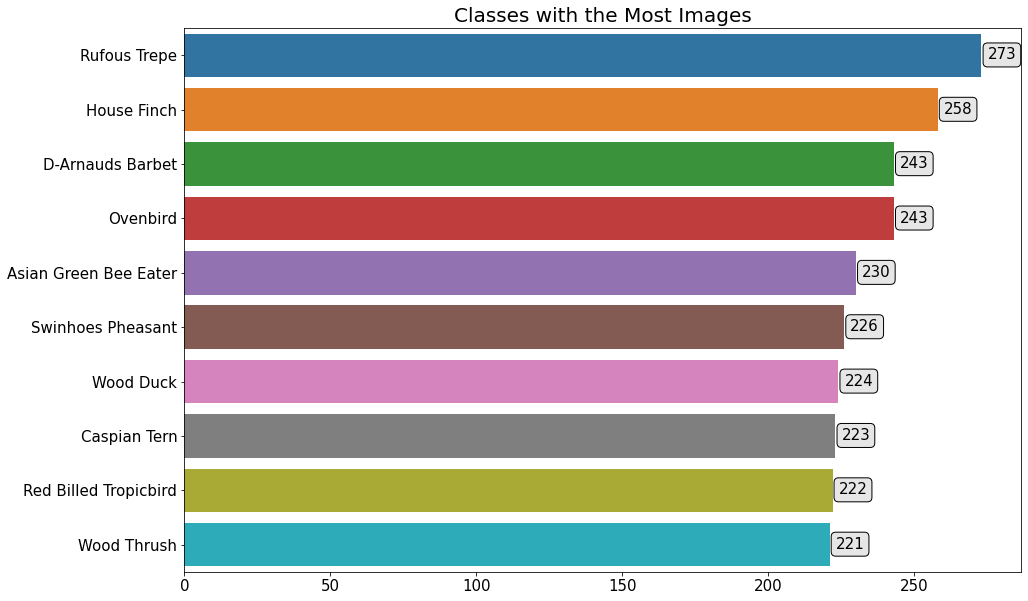

In [15]:
keys = birds_df["labels"].value_counts().index.tolist()[0:10]
keys = [bird.title() for bird in keys]
values = birds_df["labels"].value_counts().to_list()[0:10]
plt.figure(figsize = (15, 10))
ax = sns.barplot(x = values, y = keys)
plt.title("Classes with the Most Images", fontsize = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)

bbox_args = dict(boxstyle="round", fc="0.9")
for p in ax.patches:
    width = p.get_width()
    plt.text(7 + p.get_width(), p.get_y() + 0.49 * p.get_height(),
             "{:.0f}".format(width),
             ha="center", va="center",
             color="black",
             bbox=bbox_args,
             fontsize=15)

plt.show()

In [16]:
# train_df = (birds_df.groupby(birds_df["new_train_valid_test_80_10_10"])).get_group("train")
# valid_df = (birds_df.groupby(birds_df["new_train_valid_test_80_10_10"])).get_group("valid")
# test_df = (birds_df.groupby(birds_df["new_train_valid_test_80_10_10"])).get_group("test")
# train_df

In [17]:
# valid_df

In [18]:
# test_df

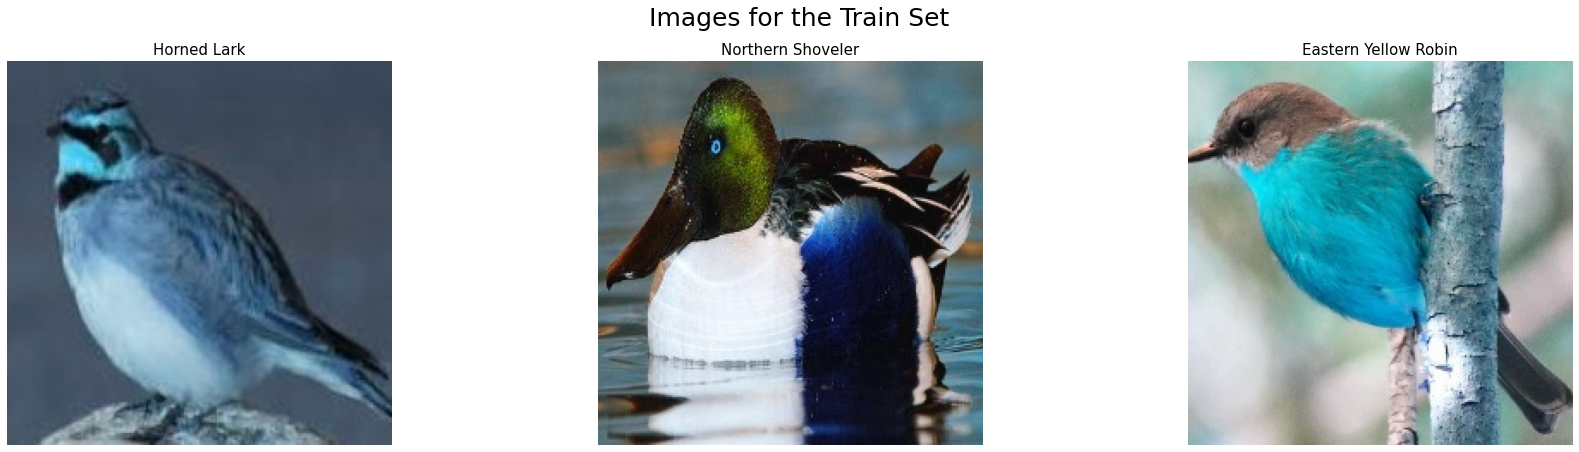

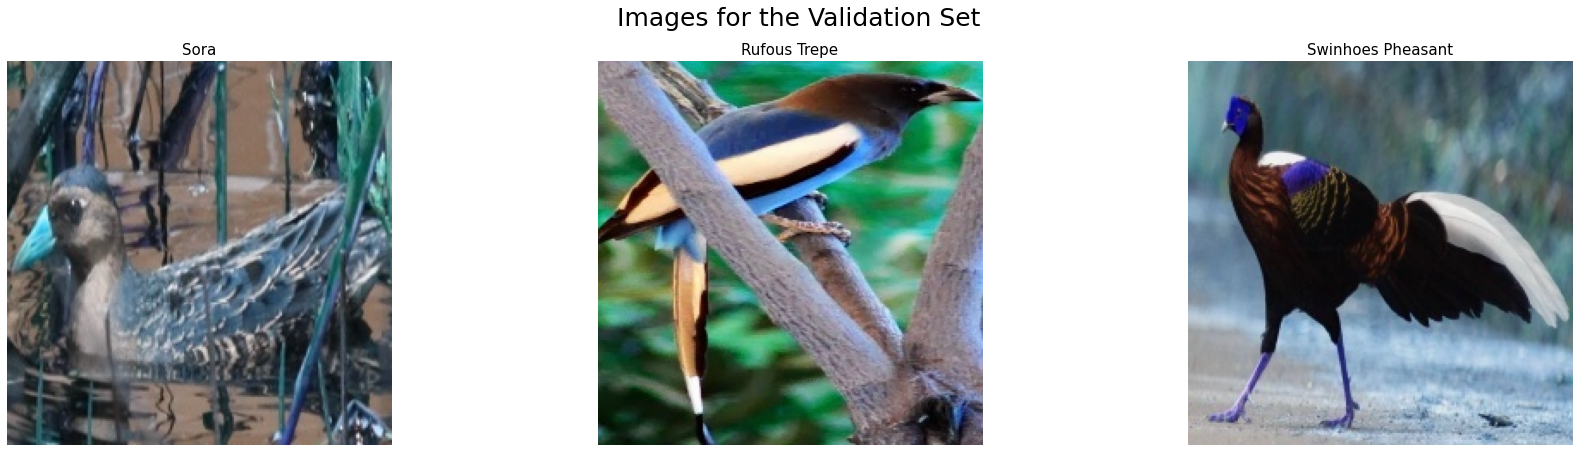

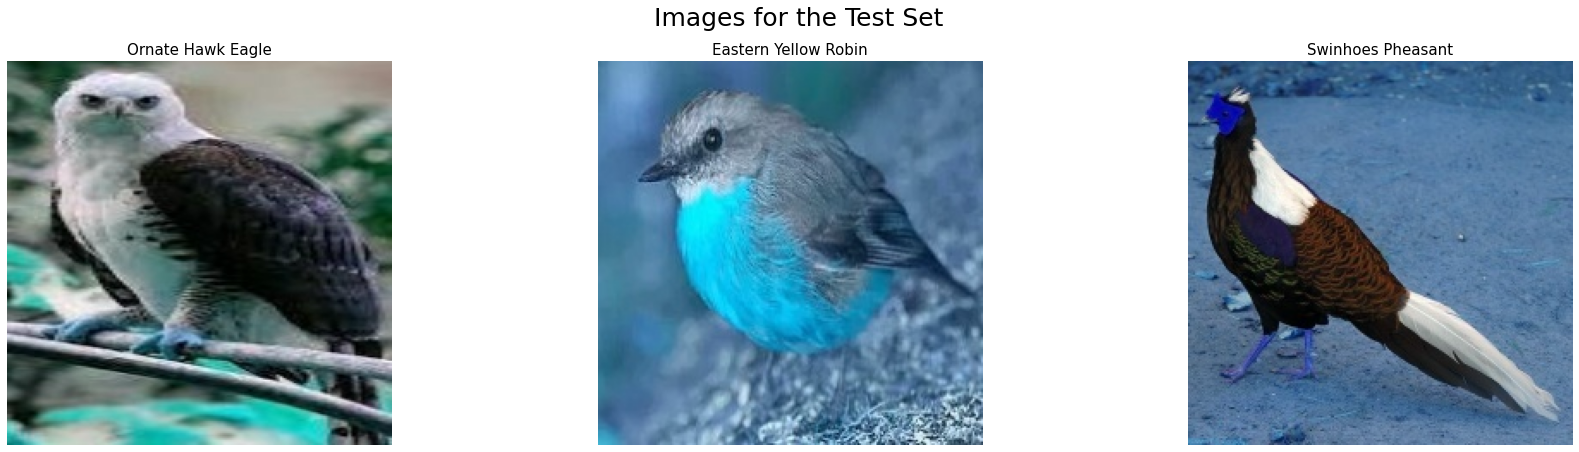

In [19]:
def plot_random_images(dataframe, type_of_set):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))
    
    plt.suptitle("Images for the " + type_of_set + " Set", fontsize=25)
    
    random_list = []
    
    for i in range(0, 3):
        random_number = random.randint(0, len(dataframe))
        random_list.append(random_number)
        
    for i in range(3):
        axes[i].imshow(cv2.imread(train_df.iloc[random_list[i], 1]))
        axes[i].set_title(train_df.iloc[random_list[i], 2].title(), fontsize=15)
        axes[i].axis("off")
        
    plt.tight_layout(rect = [0, 0.2, 0.99, 0.975])
    plt.show()
    print("\n\n")
    
plot_random_images(train_df, "Train")
plot_random_images(valid_df, "Validation")
plot_random_images(test_df, "Test")

In [20]:
train_datagen = ImageDataGenerator(rescale = 1 / 255.0,
                                   rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

valid_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_datagen = ImageDataGenerator(rescale = 1 / 255.0)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    x_col = 'filepaths',
                                                    y_col = 'labels',
                                                    target_size = GLOBAL.IMAGE_SIZE,
                                                    batch_size = GLOBAL.BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

valid_generator = valid_datagen.flow_from_dataframe(dataframe = valid_df,
                                                    x_col = 'filepaths',
                                                    y_col = 'labels',
                                                    target_size = GLOBAL.IMAGE_SIZE,
                                                    batch_size = GLOBAL.BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle = False)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                  x_col = 'filepaths',
                                                  y_col = 'labels',
                                                  target_size = GLOBAL.IMAGE_SIZE,
                                                  batch_size = GLOBAL.BATCH_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 56987 validated image filenames belonging to 400 classes.
Found 7210 validated image filenames belonging to 400 classes.
Found 7210 validated image filenames belonging to 400 classes.


In [21]:
print(train_generator.class_indices)

{'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN EMERALD CUCKOO': 3, 'AFRICAN OYSTER CATCHER': 4, 'AFRICAN PIED HORNBILL': 5, 'AFRICAN PYGMY GOOSE': 6, 'ALBERTS TOWHEE': 7, 'ALEXANDRINE PARAKEET': 8, 'ALPINE CHOUGH': 9, 'ALTAMIRA YELLOWTHROAT': 10, 'AMERICAN AVOCET': 11, 'AMERICAN BITTERN': 12, 'AMERICAN COOT': 13, 'AMERICAN DIPPER': 14, 'AMERICAN FLAMINGO': 15, 'AMERICAN KESTREL': 16, 'AMERICAN PIPIT': 17, 'AMERICAN ROBIN': 18, 'AMERICAN WIGEON': 19, 'ANDEAN SISKIN': 20, 'ANHINGA': 21, 'ANIANIAU': 22, 'ANTBIRD': 23, 'APAPANE': 24, 'APOSTLEBIRD': 25, 'ARARIPE MANAKIN': 26, 'ASHY STORM PETREL': 27, 'ASHY THRUSHBIRD': 28, 'ASIAN CRESTED IBIS': 29, 'ASIAN GREEN BEE EATER': 30, 'ASIAN OPENBILL STORK': 31, 'AUCKLAND SHAQ': 32, 'AUSTRAL CANASTERO': 33, 'AUSTRALASIAN FIGBIRD': 34, 'AVADAVAT': 35, 'AZARAS SPINETAIL': 36, 'AZURE TIT': 37, 'BAIKAL TEAL': 38, 'BALD EAGLE': 39, 'BALD IBIS': 40, 'BANANAQUIT': 41, 'BAND TAILED GUAN': 42, 'BANDED BROADBILL': 43, 'B

In [22]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

In [23]:
# mobielnet_v2_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False,
#                                                                     weights = 'imagenet',
#                                                                     input_shape = GLOBAL.INPUT_SHAPE)

vit_model = vit.vit_l32(image_size=GLOBAL.IMAGE_SIZE[0], activation="softmax", 
                        pretrained=True, include_top=False,
                        pretrained_top=False, classes=400)
vit_model.trainable = False

total_params = vit_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in vit_model.trainable_weights])

print(f"There are {total_params:,} total parameters in the pre-trained vit_b_132 model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

1226670080/1226658854 [==============================] - 5s 0us/step
There are 305,510,400 total parameters in the pre-trained vit_b_132 model.
There are 0 trainable parameters in this model.


In [24]:
vit_model.summary()

Model: "vit-l32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 7, 7, 1024)        3146752   
_________________________________________________________________
reshape (Reshape)            (None, 49, 1024)          0         
_________________________________________________________________
class_token (ClassToken)     (None, 50, 1024)          1024      
_________________________________________________________________
Transformer/posembed_input ( (None, 50, 1024)          51200     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 50, 1024), (None, 12596224  
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 50, 1024), (None, 1259

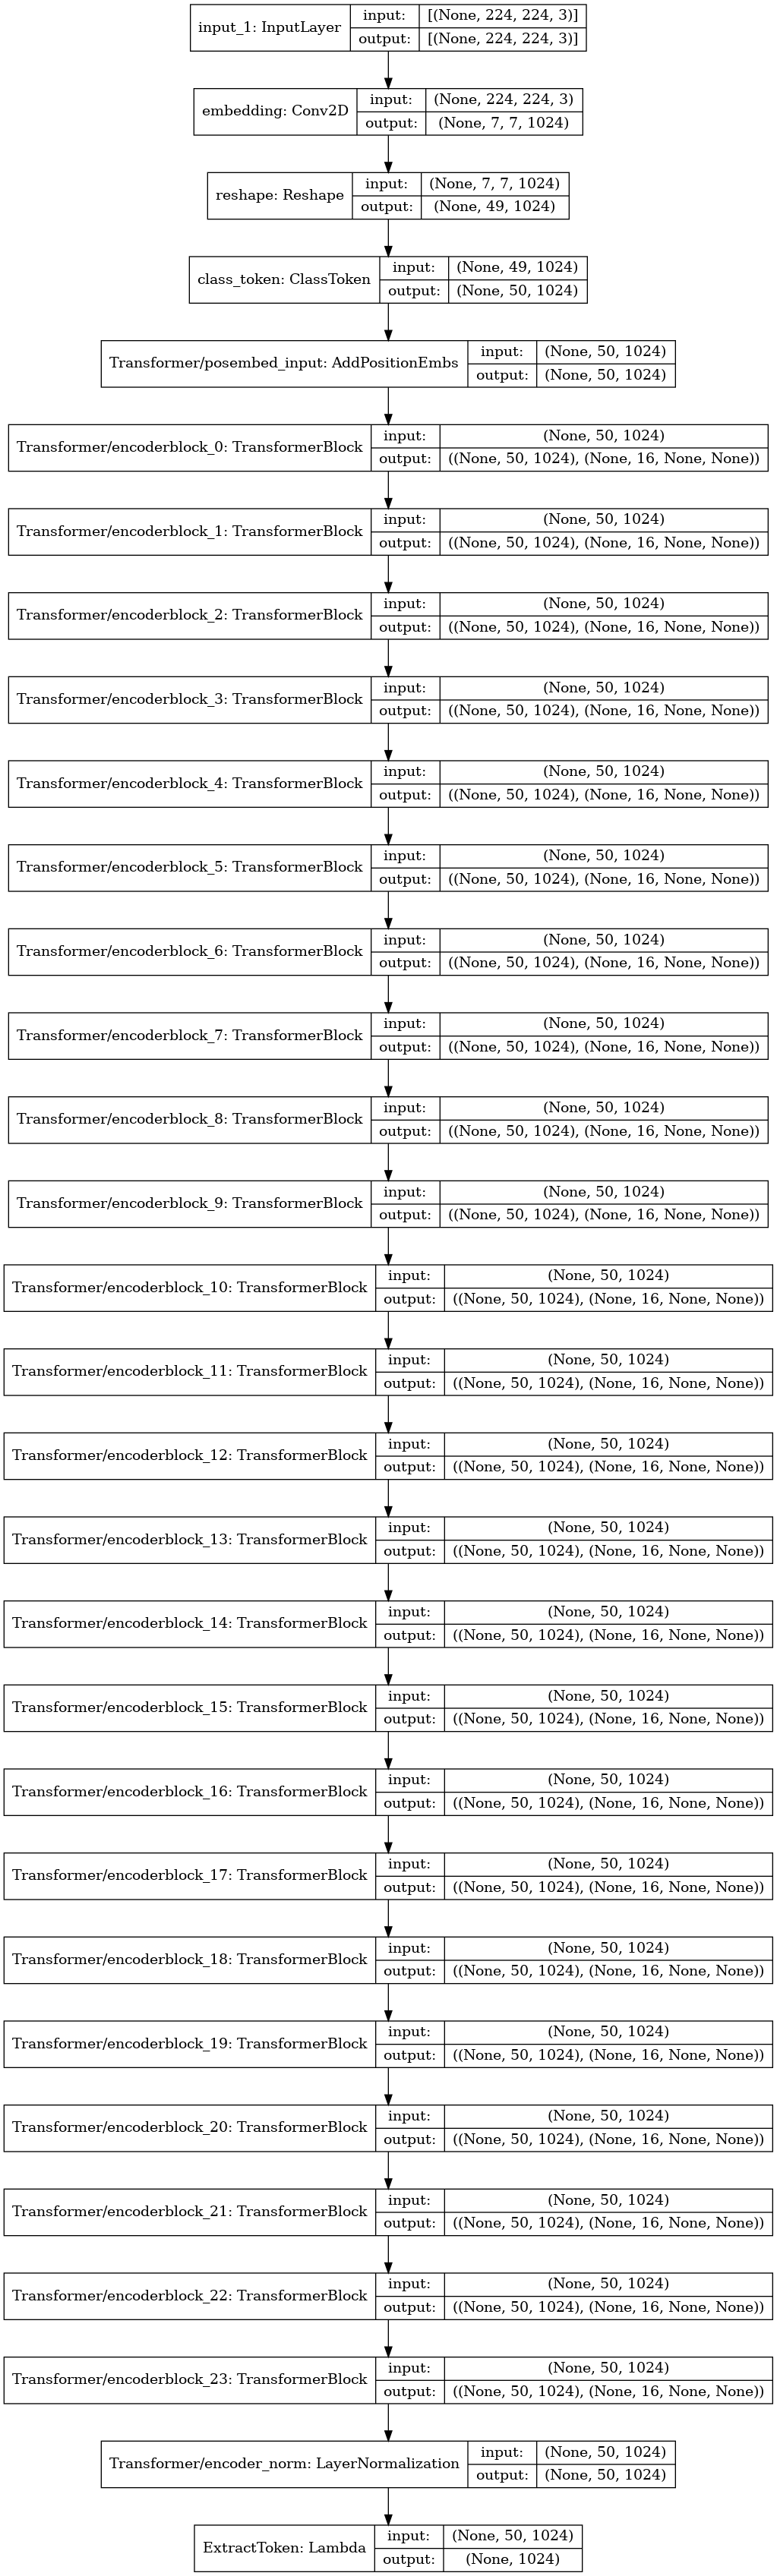

In [25]:
plot_model(vit_model, show_shapes=True)

In [26]:
vit_b132_model = Sequential([
    vit_model,
    Flatten(),
    Dropout(0.2),
    Dense(units = 1024, activation = 'relu'),
    BatchNormalization(),
    Dense(units = 400, activation = 'softmax')
])

vit_b132_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics = ['acc']
)

In [27]:
vit_b132_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-l32 (Functional)         (None, 1024)              305510400 
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               410000    
Total params: 306,974,096
Trainable params: 1,461,648
Non-trainable params: 305,512,448
__________________________________

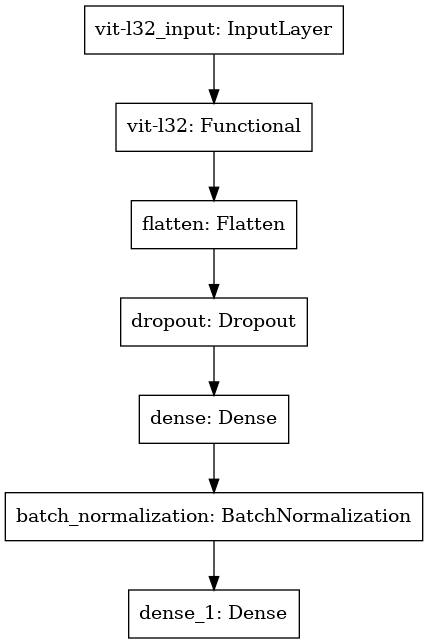

In [28]:
plot_model(vit_b132_model)

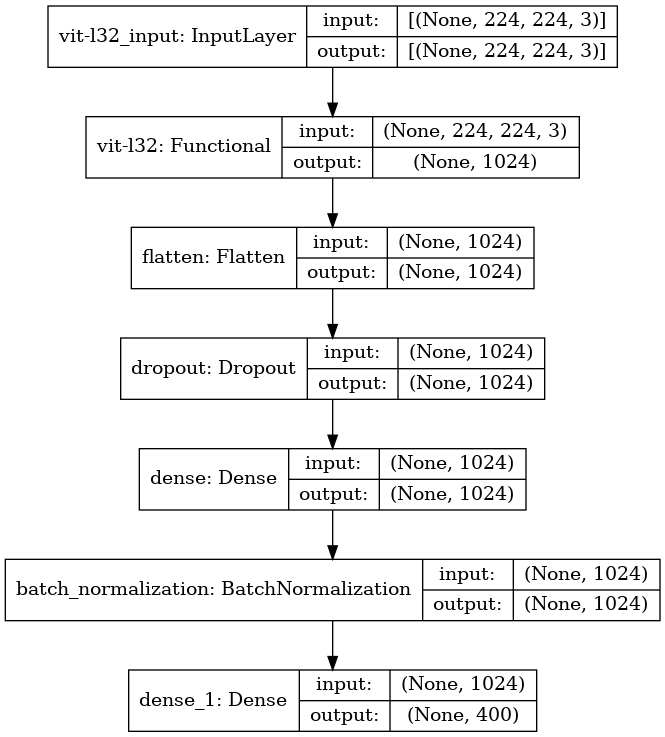

In [29]:
plot_model(vit_b132_model, show_shapes = True)

In [30]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
early_stop = EarlyStopping(monitor = 'val_acc', patience = 3)

In [31]:
classifier = vit_b132_model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 15,
    verbose = 1,
    callbacks = [reduce_lr, early_stop]
)

Epoch 1/15
1781/1781 [==============================] - 1006s 550ms/step - loss: 0.9627 - acc: 0.7698 - val_loss: 0.4396 - val_acc: 0.8846
Epoch 2/15
1781/1781 [==============================] - 789s 443ms/step - loss: 0.5464 - acc: 0.8558 - val_loss: 0.4386 - val_acc: 0.8942
Epoch 3/15
1781/1781 [==============================] - 802s 450ms/step - loss: 0.4590 - acc: 0.8774 - val_loss: 0.3890 - val_acc: 0.9044
Epoch 4/15
1781/1781 [==============================] - 786s 441ms/step - loss: 0.4000 - acc: 0.8895 - val_loss: 0.3737 - val_acc: 0.9098
Epoch 5/15
1781/1781 [==============================] - 796s 447ms/step - loss: 0.3696 - acc: 0.8968 - val_loss: 0.3447 - val_acc: 0.9186
Epoch 6/15
1781/1781 [==============================] - 784s 440ms/step - loss: 0.3347 - acc: 0.9051 - val_loss: 0.3321 - val_acc: 0.9173
Epoch 7/15
1781/1781 [==============================] - 788s 442ms/step - loss: 0.3094 - acc: 0.9122 - val_loss: 0.3326 - val_acc: 0.9169

Epoch 00007: ReduceLROnPlateau r

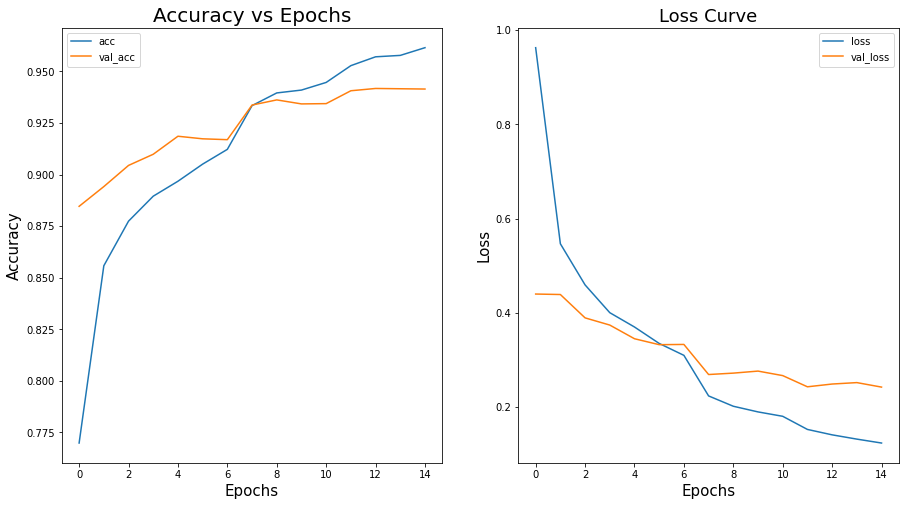

In [32]:
def model_performance_graphs(classifier):
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['acc'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_acc'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs(classifier)

In [33]:
test_set_results = vit_b132_model.evaluate(test_generator)
print('Test Set Accuracy: {} %'.format(test_set_results[1] * 100))

226/226 [==============================] - 55s 245ms/step - loss: 0.2371 - acc: 0.9427
Test Set Accuracy: 94.27184462547302 %


In [34]:
vit_b132_model.save('../working/bird_classifier_vit_b132.h5')

In [35]:
model = tf.keras.models.load_model('../working/bird_classifier_vit_b132.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
open('../working/bird_classifier_vit_b132.h5.tflite', 'wb').write(tflite_model)

1228440532

In [36]:
predictions = model.predict_generator(test_generator)
print(len(predictions[0]))
final_labels = np.argmax(predictions, axis = 1)
print(final_labels)
df = pd.DataFrame(final_labels)
df.value_counts()

400
[ 46 236  91 ...   6 280  41]


326    29
216    27
150    26
117    26
278    25
       ..
145    11
188    11
36     11
297     9
161     8
Length: 400, dtype: int64

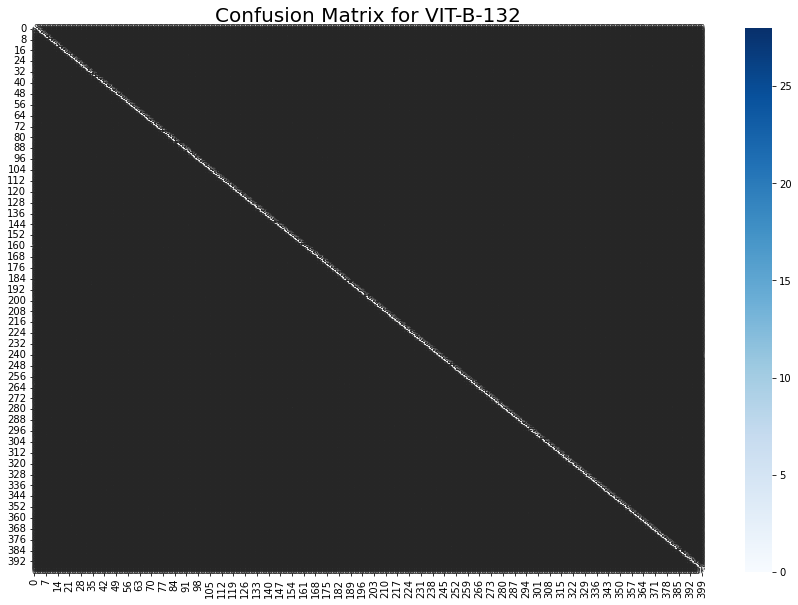

In [37]:
def plot_confusion_matrix(y_true, y_pred, model_name):

    plt.figure(figsize=(15, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), cmap="Blues", annot=True, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix for {model_name.upper()}", fontsize=20)
    plt.show()
    
plot_confusion_matrix(test_generator.classes, final_labels, "VIT-B-132")

In [38]:
print(f"Recall Score: {recall_score(test_generator.classes, final_labels, average='weighted')}")
print(f"Precision Score: {precision_score(test_generator.classes, final_labels, average='weighted')}")
print(f"F1 Score: {f1_score(test_generator.classes, final_labels, average='weighted')}")

Recall Score: 0.9427184466019417
Precision Score: 0.9464555917168956
F1 Score: 0.9422936339889818


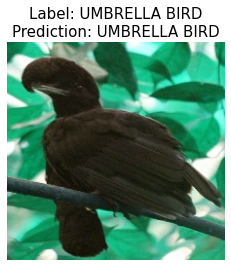

In [39]:
random_number = random.randint(0, len(test_df))
img = cv2.imread(test_df.iloc[random_number, 1])

rescaled_image = img / 255.0
resized_image = cv2.resize(rescaled_image, (224, 224))
model_input_image = np.expand_dims(resized_image, axis = 0)
prediction = model.predict(model_input_image)
final_prediction = np.argmax(prediction, axis=1)

matching_keys = [key for key, value in train_generator.class_indices.items() if value == final_prediction[0]]

plt.imshow(img)
plt.title(f"Label: {test_df.iloc[random_number, 2]}\nPrediction: {matching_keys[0]}", fontsize=15)
plt.axis("off")
plt.show()

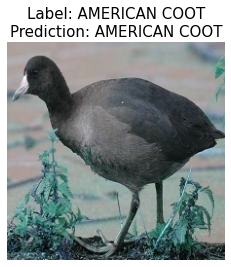

In [40]:
path = '/kaggle/input/100-bird-species/test/AMERICAN COOT/3.jpg'
img = cv2.imread(path)

rescaled_image = img / 255.0
resized_image = cv2.resize(rescaled_image, (224, 224))
model_input_image = np.expand_dims(resized_image, axis = 0)
prediction = model.predict(model_input_image)
final_prediction = np.argmax(prediction, axis = 1)

matching_keys = [key for key, value in train_generator.class_indices.items() if value == final_prediction[0]]

plt.imshow(img)
plt.title(f"Label: {path.split('/')[-2]}\nPrediction: {matching_keys[0]}", fontsize=15)
plt.axis("off")
plt.show()